In [1]:
# import logging
import pandas as pd
from tqdm import tqdm 
import torch
import torch.nn as  nn 
from torch.utils.data import DataLoader
import erc
import os
import pickle

from sklearn.manifold import TSNE
from sklearn.datasets import load_digits


ModuleNotFoundError: No module named 'sklearn'

In [3]:
from glob import glob 

# load pickle --> RAM 
SAVE_PATH = "./RobertaL_valid_results"


total_emotion = pd.DataFrame()
total_wav_pooled = pd.DataFrame()
total_txt_pooled = pd.DataFrame()

pbar = tqdm(
    total=int(len(glob(SAVE_PATH+'/*.pickle'))), 
    iterable = glob(SAVE_PATH+'/*.pickle'))

for pickle_name in pbar:
    # load
    with open(pickle_name, 'rb') as f:
        data = pickle.load(f)
    # print(data)
    tmp_emotion = pd.DataFrame(data['emotion'].detach().numpy())
    tmp_wav_pooled = pd.DataFrame(data["wav_pooled"])
    tmp_txt_pooled = pd.DataFrame(data["txt_pooled"])
    
    total_emotion = pd.concat([total_emotion,tmp_emotion ], axis=0)
    total_wav_pooled = pd.concat([total_wav_pooled,tmp_wav_pooled ], axis=0)
    total_txt_pooled = pd.concat([total_txt_pooled,tmp_txt_pooled ], axis=0)

total_emotion.columns = ['emotion']


100%|██████████| 585/585 [00:01<00:00, 530.76it/s] 


## UMAP 

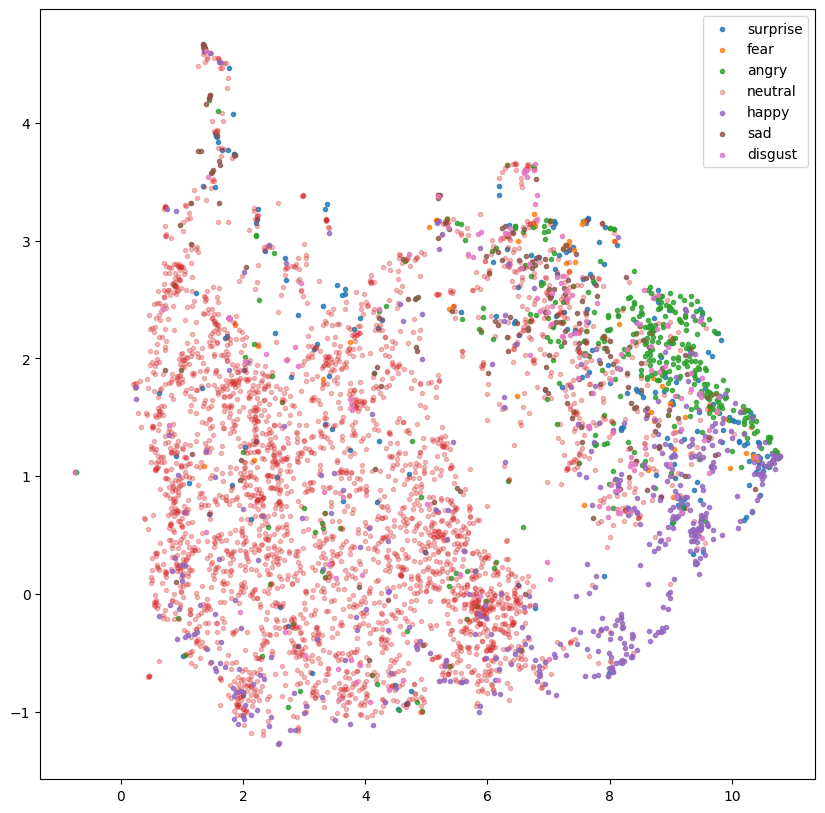

In [45]:
import matplotlib.pyplot as plt 
import numpy as np 
import umap


# - 2d 

wav_txt = pd.concat([total_wav_pooled,total_txt_pooled ], axis=1)

cluster = umap.UMAP(random_state=42,
    n_neighbors=7,
    min_dist=0.0,
    n_components=2
                    ).fit_transform(wav_txt.values)
actual = total_emotion.values

plt.figure(figsize=(10, 10))
cifar = ['surprise', 'fear', 'angry', 'neutral', 'happy', 'sad', 'disgust']
for i, label in zip(range(10), cifar):
    idx = np.where(actual == i)
    if i == 3:
        plt.scatter(cluster[idx, 0], cluster[idx, 1], marker='.', label=label, alpha = 0.3)
    else: 
        plt.scatter(cluster[idx, 0], cluster[idx, 1], marker='.', label=label, alpha = 0.8)

plt.legend()
plt.show()

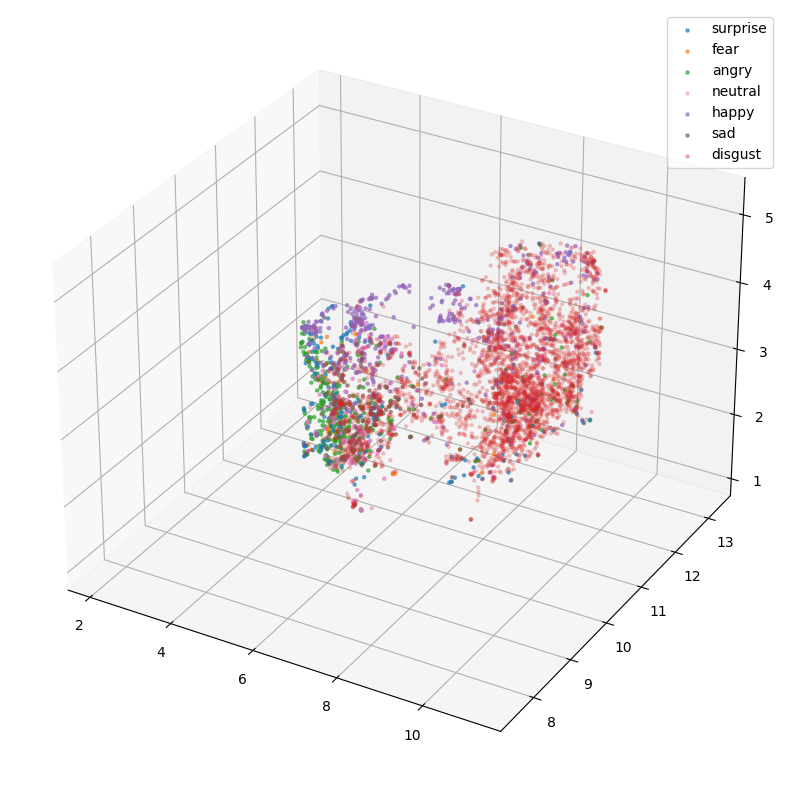

In [50]:
import matplotlib.pyplot as plt 
import numpy as np 
import umap


# - 3d 

wav_txt = pd.concat([total_wav_pooled,total_txt_pooled ], axis=1)

cluster = umap.UMAP(random_state=42,
    n_neighbors=7,
    min_dist=0.0,
    n_components=3
                    ).fit_transform(wav_txt.values)
actual = total_emotion.values


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
cifar = ['surprise', 'fear', 'angry', 'neutral', 'happy', 'sad', 'disgust']
for i, label in zip(range(10), cifar):
    idx = np.where(actual == i)
    if i == 3:
        ax.scatter(cluster[idx, 0], cluster[idx, 1],cluster[idx, 2], marker='.', label=label, alpha = 0.2)
        # plt.scatter(cluster[idx, 0], cluster[idx, 1],cluster[idx, 2], marker='.', label=label, alpha = 0.3)
    else: 
        ax.scatter(cluster[idx, 0], cluster[idx, 1],cluster[idx, 2], marker='.', label=label, alpha = 0.6)
        # plt.scatter(cluster[idx, 0], cluster[idx, 1],cluster[idx, 2], marker='.', label=label, alpha = 0.8)

plt.legend()
plt.show()

In [62]:
# !pip install plotly==5.14.1
import plotly.express as px

df = pd.DataFrame(cluster, columns = ['x','y','z'])
df['emotion'] = actual
fig = px.scatter_3d(df, x='x', y='y', z='z',
                    color='emotion',
                    #   symbol='emotion',
                    size_max=2,
                    opacity=0.7,
              )
fig.show()

In [66]:
import matplotlib.pyplot as plt 
import numpy as np 
import umap


# - 3d 

# wav_txt = pd.concat([total_wav_pooled,total_txt_pooled ], axis=1)

cluster = umap.UMAP(random_state=42,
    n_neighbors=7,
    min_dist=0.0,
    n_components=3
                    ).fit_transform(total_wav_pooled.values)
actual = total_emotion.values

df = pd.DataFrame(cluster, columns = ['x','y','z'])
df['emotion'] = actual
fig = px.scatter_3d(df, x='x', y='y', z='z',
                    color='emotion',
                    #   symbol='emotion',
                    size_max=2,
                    opacity=0.7,
              )
fig.show()

In [65]:
import matplotlib.pyplot as plt 
import numpy as np 
import umap


# - 3d 

# wav_txt = pd.concat([total_wav_pooled,total_txt_pooled ], axis=1)

cluster = umap.UMAP(random_state=42,
    n_neighbors=7,
    min_dist=0.0,
    n_components=3
                    ).fit_transform(total_txt_pooled.values)
actual = total_emotion.values


df = pd.DataFrame(cluster, columns = ['x','y','z'])
df['emotion'] = actual
fig = px.scatter_3d(df, x='x', y='y', z='z',
                    color='emotion',
                    #   symbol='emotion',
                    size_max=2,
                    opacity=0.2,
              )
fig.show()

In [68]:
import matplotlib.pyplot as plt 
import numpy as np 
import umap


# - 3d 

# wav_txt = pd.concat([total_wav_pooled,total_txt_pooled ], axis=1)

wav_cluster = umap.UMAP(random_state=42,
    n_neighbors=7,
    min_dist=0.0,
    n_components=3
                    ).fit_transform((total_wav_pooled).values)

txt_cluster = umap.UMAP(random_state=42,
    n_neighbors=7,
    min_dist=0.0,
    n_components=3
                    ).fit_transform((total_txt_pooled).values)


actual = total_emotion.values


df = pd.DataFrame(wav_cluster*txt_cluster, columns = ['x','y','z'])
df['emotion'] = actual
fig = px.scatter_3d(df, x='x', y='y', z='z',
                    color='emotion',
                    #   symbol='emotion',
                    size_max=2,
                    opacity=0.2,
              )
fig.show()

In [86]:
import matplotlib.pyplot as plt 
import numpy as np 
import umap
from sklearn.preprocessing   import MinMaxScaler

# - 3d 

# wav_txt = pd.concat([total_wav_pooled,total_txt_pooled ], axis=1)

wav_cluster = umap.UMAP(random_state=42,
    n_neighbors=7,
    # min_dist=0.0,
    n_components=3
                    ).fit_transform((total_wav_pooled).values)

txt_cluster = umap.UMAP(random_state=42,
    n_neighbors=7,
    # min_dist=0.0,
    n_components=3
                    ).fit_transform((total_txt_pooled).values)


actual = total_emotion.values



scaler = MinMaxScaler(feature_range=(-1,1))

df = pd.DataFrame(scaler.fit_transform(wav_cluster)*scaler.fit_transform(txt_cluster), columns = ['x','y','z'])
df['emotion'] = actual
fig = px.scatter(df, x='x', y='y',
                    color='emotion',
                    #   symbol='emotion',
                    size_max=2,
                    opacity=0.2,
              )
fig.show()

## PCA 


In [40]:
matmul_output = torch.bmm(torch.from_numpy(total_wav_pooled.values).unsqueeze(2),
                          torch.from_numpy(total_txt_pooled.values).unsqueeze(1))

In [41]:
matmul_output.shape

torch.Size([4678, 256, 256])

In [44]:
matmul_output.mean().shape

torch.Size([])

In [33]:
total_wav_pooled.shape

(4678, 256)

In [34]:
total_txt_pooled.shape

(4678, 256)

In [28]:
wav_txt = pd.concat([total_wav_pooled,total_txt_pooled ], axis=1)

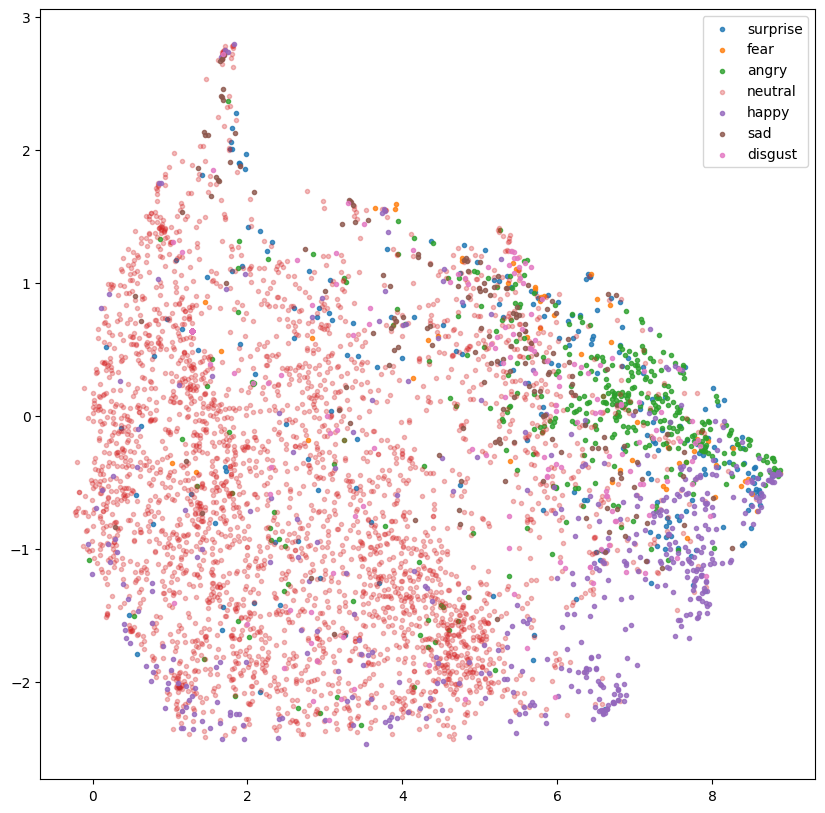

In [32]:
import matplotlib.pyplot as plt 
import numpy as np 
import umap

# tsne = TSNE(n_components=2, random_state=42) # 사실 easy 함 sklearn 사용하니..
# cluster = np.array(tsne.fit_transform(total_txt_pooled.values))

cluster = umap.UMAP(random_state=42,
                    # n_neighbors=6,
    min_dist=0.0,
    n_components=2
                    ).fit_transform(wav_txt.values)
actual = total_emotion.values

plt.figure(figsize=(10, 10))
cifar = ['surprise', 'fear', 'angry', 'neutral', 'happy', 'sad', 'disgust']
for i, label in zip(range(10), cifar):
    idx = np.where(actual == i)
    if i == 3:
        plt.scatter(cluster[idx, 0], cluster[idx, 1], marker='.', label=label, alpha = 0.3)
    else: 
        plt.scatter(cluster[idx, 0], cluster[idx, 1], marker='.', label=label, alpha = 0.8)

plt.legend()
plt.show()

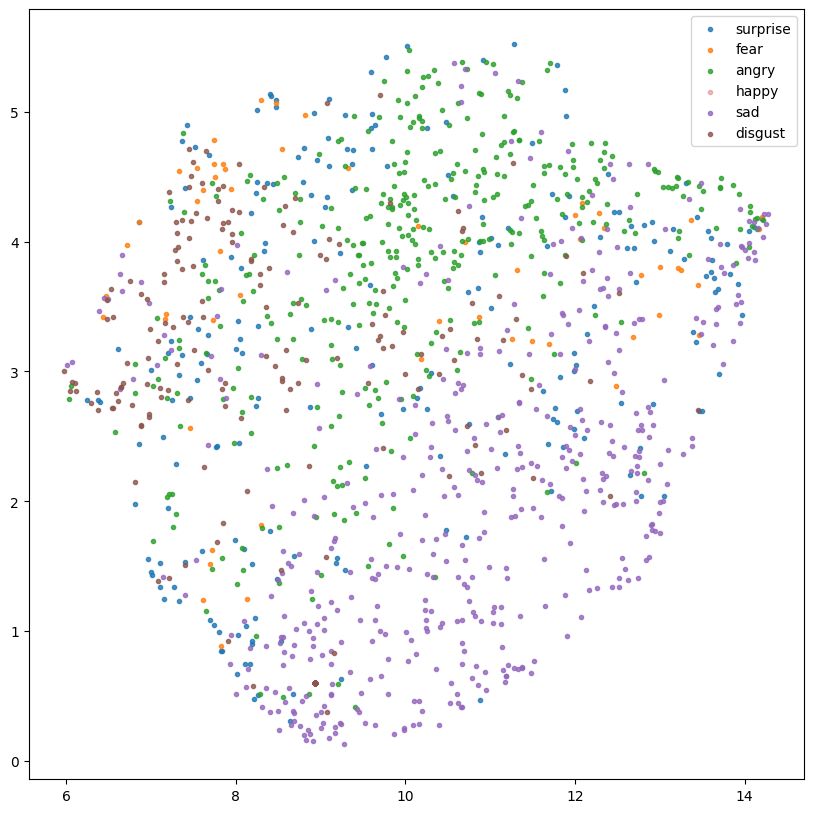

In [26]:
import matplotlib.pyplot as plt 
import numpy as np 
import umap

# tsne = TSNE(n_components=2, random_state=42) # 사실 easy 함 sklearn 사용하니..
# cluster = np.array(tsne.fit_transform(total_txt_pooled.values))

cluster = umap.UMAP(random_state=42,
                    # n_neighbors=6,
    # min_dist=0.2,
    n_components=2
                    ).fit_transform(total_wav_pooled[total_emotion['emotion'] != 3].values)
actual = total_emotion[total_emotion['emotion'] != 3].values

plt.figure(figsize=(10, 10))
cifar = ['surprise', 'fear', 'angry', 'happy', 'sad', 'disgust']
for i, label in zip(range(10), cifar):
    idx = np.where(actual == i)
    if i == 3:
        plt.scatter(cluster[idx, 0], cluster[idx, 1], marker='.', label=label, alpha = 0.3)
    else: 
        plt.scatter(cluster[idx, 0], cluster[idx, 1], marker='.', label=label, alpha = 0.8)

plt.legend()
plt.show()

In [9]:
# wav_txt= pd.concat([total_wav_pooled,total_txt_pooled ], axis=1)


wav_txt = total_wav_pooled * total_txt_pooled

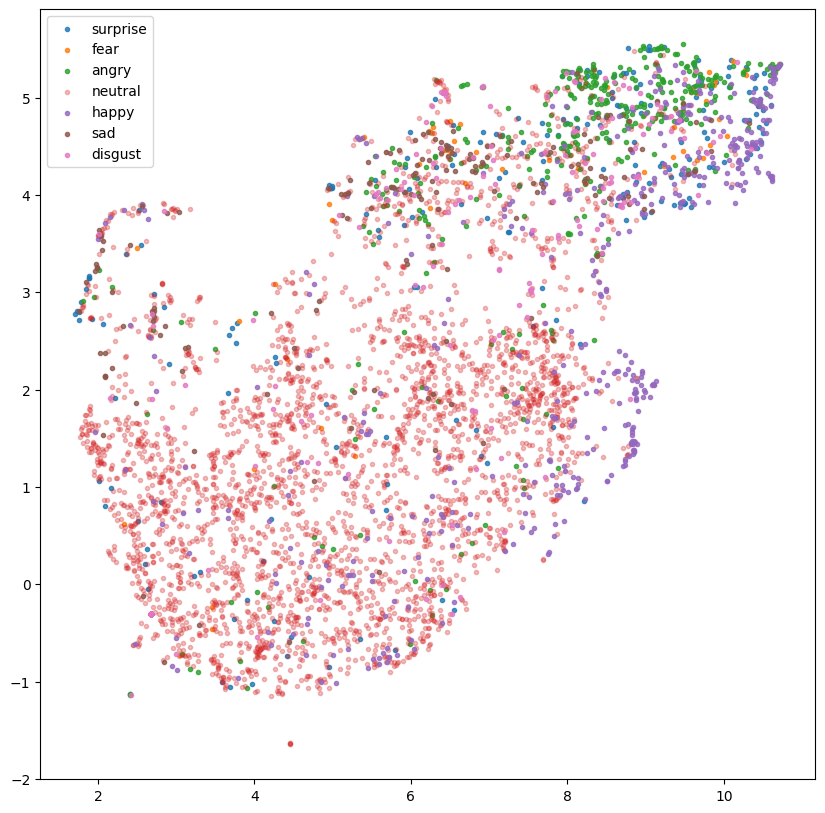

In [10]:
import matplotlib.pyplot as plt 
import numpy as np 
import umap

# tsne = TSNE(n_components=2, random_state=42) # 사실 easy 함 sklearn 사용하니..
# cluster = np.array(tsne.fit_transform(total_txt_pooled.values))

cluster = umap.UMAP(random_state=42,
                    n_neighbors=7,
    min_dist=0.0,
    n_components=2
                    ).fit_transform(wav_txt.values)
actual = total_emotion.values

plt.figure(figsize=(10, 10))
cifar = ['surprise', 'fear', 'angry', 'neutral', 'happy', 'sad', 'disgust']
for i, label in zip(range(10), cifar):
    idx = np.where(actual == i)
    if i == 3:
        plt.scatter(cluster[idx, 0], cluster[idx, 1], marker='.', label=label, alpha = 0.3)
    else: 
        plt.scatter(cluster[idx, 0], cluster[idx, 1], marker='.', label=label, alpha = 0.8)

plt.legend()
plt.show()

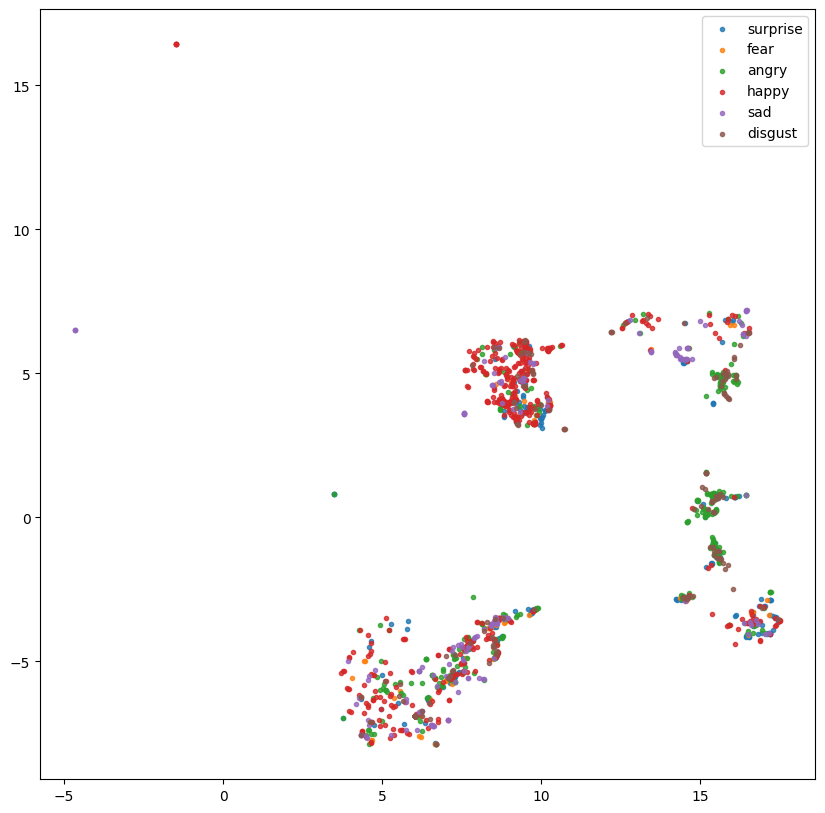

In [11]:
import matplotlib.pyplot as plt 
import numpy as np 
import umap

# tsne = TSNE(n_components=2, random_state=42) # 사실 easy 함 sklearn 사용하니..
# cluster = np.array(tsne.fit_transform(total_txt_pooled.values))

cluster = umap.UMAP(random_state=42,
                    n_neighbors=7,
    min_dist=0.0,
    n_components=2
                    ).fit_transform(total_txt_pooled.values)
actual = total_emotion.values

plt.figure(figsize=(10, 10))
cifar = ['surprise', 'fear', 'angry', 'neutral', 'happy', 'sad', 'disgust']
for i, label in zip(range(10), cifar):
    idx = np.where(actual == i)
    if i == 3:
        # plt.scatter(cluster[idx, 0], cluster[idx, 1], marker='.', label=label, alpha = 0.3)
        pass
    else: 
        plt.scatter(cluster[idx, 0], cluster[idx, 1], marker='.', label=label, alpha = 0.8)

plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt 
import numpy as np 

tsne = TSNE(n_components=2, random_state=42) # 사실 easy 함 sklearn 사용하니..
cluster = np.array(tsne.fit_transform(total_txt_pooled.values))

actual = total_emotion.values

plt.figure(figsize=(10, 10))
cifar = ['surprise', 'fear', 'angry', 'neutral', 'happy', 'sad', 'disgust']
for i, label in zip(range(10), cifar):
    idx = np.where(actual == i)
    if i == 3:
        plt.scatter(cluster[idx, 0], cluster[idx, 1], marker='.', label=label, alpha = 0.3)
    else: 
        plt.scatter(cluster[idx, 0], cluster[idx, 1], marker='.', label=label, alpha = 0.8)

plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt 
import numpy as np 

tsne = TSNE(n_components=2, random_state=42) # 사실 easy 함 sklearn 사용하니..
cluster = np.array(tsne.fit_transform(total_wav_pooled.values))
actual = total_emotion.values

plt.figure(figsize=(10, 10))
cifar = ['surprise', 'fear', 'angry', 'neutral', 'happy', 'sad', 'disgust']
for i, label in zip(range(10), cifar):
    idx = np.where(actual == i)
    if i == 3:
        plt.scatter(cluster[idx, 0], cluster[idx, 1], marker='.', label=label, alpha = 0.3)
    else: 
        plt.scatter(cluster[idx, 0], cluster[idx, 1], marker='.', label=label, alpha = 0.8)

plt.legend()
plt.show()

In [ ]:
total_emotion

In [ ]:
df = pd.DataFrame()
df['emotion'] = data['emotion'].detach().numpy()

In [ ]:
pd.DataFrame( data["wav_pooled"])

In [ ]:
df

In [ ]:

# MNIST 데이터 불러오기
# data = load_digits()

# 2차원으로 차원 축소
n_components = 2

# t-sne 모델 생성
model = TSNE(n_components=n_components)

# 학습한 결과 2차원 공간 값 출력
print(model.fit_transform(data.data))